<a href="https://colab.research.google.com/github/TimeNtWait/MADE_VK/blob/main/TaskSummer2022/TaskML%202/MADE_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MADE

## Соревнование 2. Подсчет квадратов на изображении

## Условия
Описание задачи:
В вашем распоряжении есть набор изображений, которые состоят из нескольких видов геометрических фигур:
- квадратов;
- прямоугольников;
- параллелограммов;
- окружностей.

Ваша задача – посчитать количество квадратов на каждом изображении из тестовых данных (https://disk.yandex.ru/d/Ptos-od6KEa-5g). Изображения для обучения можно скачать здесь (https://disk.yandex.ru/d/7qQW1ljssfOLSg).

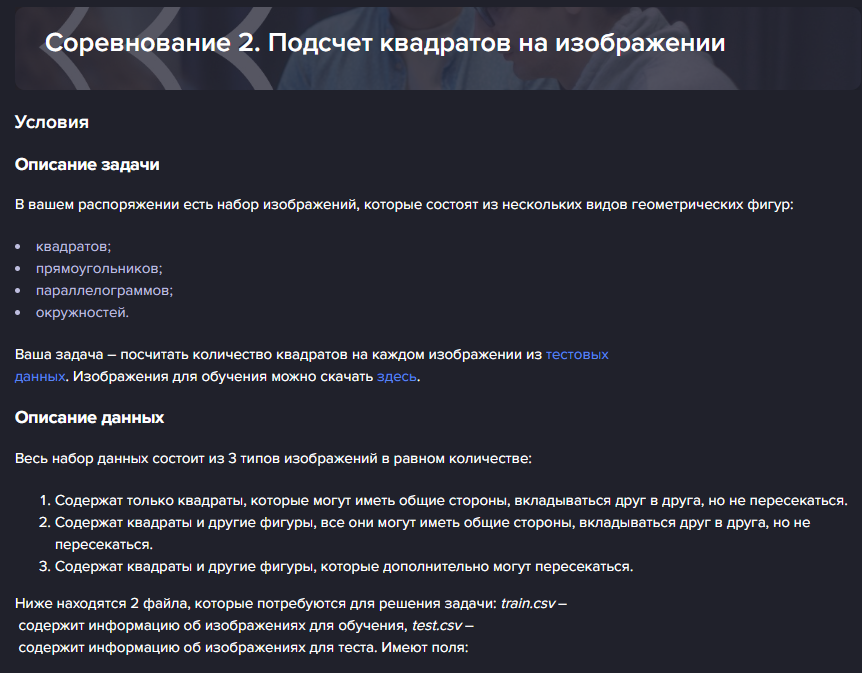

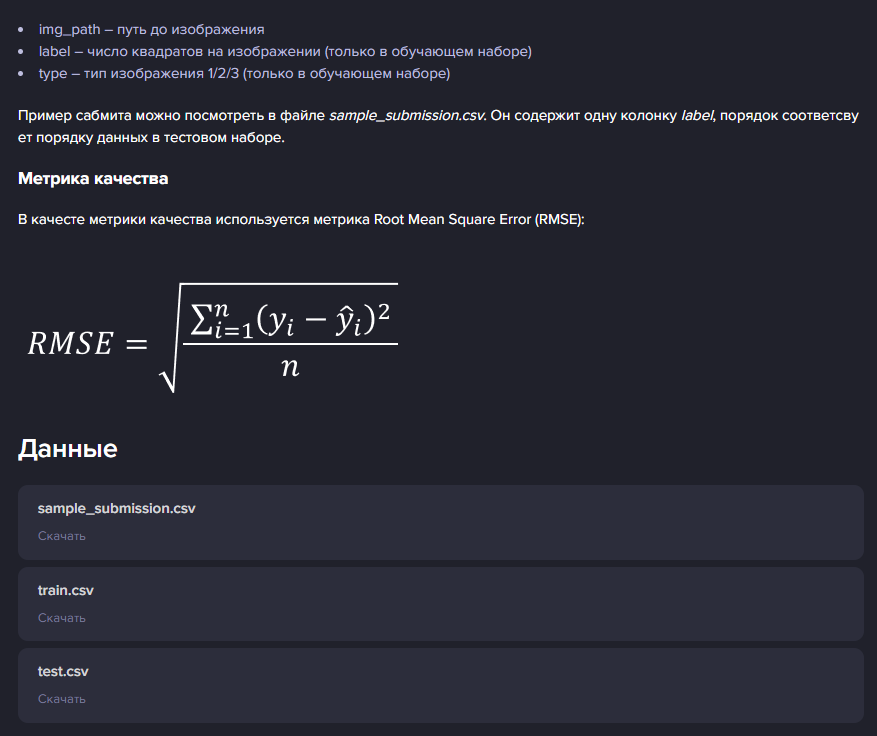

# Решение

По условию задачи планировалось делать двойное обучение с учетом типа группировки объектов на каритнке (3 способа группировки).

При этом для детекции изображения можно использовать готовые библиотеки. Так например библиотека OpenCV (https://opencv.org/) хорошо подходит под данную задачу, когда необходимо опредлеять простые фигуры с возможным пересечением.

Существенным минусом данной библиотеки является большое кол-во "лишних" и "ложных" фиксаций объектов (особо актуально для квадратов). Для решения данной проблемы использовалась дополнительная фильтрация потенциальных объектов.

# Подключение библиотек и Google диска


In [1]:
import glob
import cv2 as cv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow # стандартный  метод cv2 imshow не работает в Colab надо использовать гугловую модификацию

In [2]:
from google.colab import drive
drive.mount('/content/drive')
PATH = "drive/MyDrive/Colab Notebooks/MADE/Task 2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
predict_filename = PATH + "sample_submission.csv"
train_files = glob.glob(PATH + "train_data/" + f"/*.png")
test_files = glob.glob(PATH + "test_data/" + f"/*.png")
len(train_files), len(test_files), predict_filename

(3000, 6001, 'drive/MyDrive/Colab Notebooks/MADE/Task 2/sample_submission.csv')

## Определяем методы поиска контуров и их фильтрации на предмет принадлежности квадратам

In [4]:
def calc_length(p1, p2):
    """Рассчет расстояния между точками"""
    return ((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)**(0.5)

def calc_center_square(p1,p2):
    """Поиск центра квадрта"""
    center_square = [p1[0] + (p2[0] - p1[0]) / 2, p1[1] + (p1[0] - p1[1]) / 2]
    return center_square

def find_diagonal_point(*points):
    """Находим минимальную точку (нижнюю левую) и мксимальную (верхнюю правую)"""
    sum_points = list(map(sum,points)) 
    max_point = points[sum_points.index(max(sum_points))] 
    min_point = points[sum_points.index(min(sum_points))]
    return min_point, max_point


def detect_square(filename, is_log = False): 
    # Загружаем картинку
    img = cv.imread(filename)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Ищем контуры объектов
    _, thresh = cv.threshold(img_gray, 240, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(thresh, cv.RETR_LIST , cv.CHAIN_APPROX_TC89_L1  )
    
    # Пробегаемся по всем найденным контурам и оцениваем их принадлежность к квадрату через различные фильтры
    count_squares = 0
    find_min_points = []
    find_max_points = []
    for c in contours:
        approx = cv.approxPolyDP(c, 0.01*cv.arcLength(c, True), True)

        # Если меньше 4 точек в потенциальном контуре то это точно не квадрат, переходим к следующему контуру. Может быть больше если cv нарисовал контур не под 90 градусами а немного скосил
        # В качестве развития решения залачи можно добавить специальную обработку случаев когда точек больше 4х
        if len(approx) < 4:
            continue

        # Определяем точки контура
        p1 = [approx[0][0][0], approx[0][0][1]]
        p2 = [approx[1][0][0], approx[1][0][1]]
        p3 = [approx[2][0][0], approx[2][0][1]]
        p4 = [approx[3][0][0], approx[3][0][1]]
        # диогнальные точки левая нижняя и верхняя правая
        min_point, max_point = find_diagonal_point(p1,p2,p3,p4)

        # Рассчитываем площадь потенципльного квадрата, если она слишком маленькая, то это скорее всего выброс
        rectangle_area = abs(min_point[0] - max_point[0]) * abs(min_point[1] - max_point[1])
        if rectangle_area < 80:
            continue
        if is_log:
            print(f"rectangle_area: {rectangle_area}")

        # Иногда в качестве квадрата определяется рамка самой картинки. Исключаем такие случаи за счет условия: если две стороны и диогналь от одного угла больше 0.95 общего размера то считаем, что захвачен общий контур
        length_1_2 = calc_length(p1, p2)
        length_1_3 = calc_length(p1, p3)
        length_1_4 = calc_length(p1, p4)
        near_border_size = img.shape[0]*0.95 # определяем 95% от размера изображения в нашем случае размер 320*320
        if length_1_2 > near_border_size and length_1_3 > near_border_size and length_1_4 > near_border_size: 
            continue
        if is_log:
            print(p1, p2, p3, p4)
        
        # OpenCV генерирует много повторных контуров. Необходимо отсеять конутры которые похожи на ранее найденные 
        is_near_square = False
        for j in range(len(find_min_points)):
            length_min_point =  calc_length(find_min_points[j], min_point)
            length_max_point =  calc_length(find_max_points[j], max_point)
            if length_min_point < 7 and length_min_point < 7:
                if is_log:
                    print(f"length_min_point: {length_min_point}, length_max_point: {length_max_point}")
                is_near_square = True
                break
        if is_near_square:
            continue
        find_min_points.append(min_point)
        find_max_points.append(max_point)
        
        if len(approx) >= 4 and len(approx) < 9:
            x1, y1, w, h = cv.boundingRect(approx)
            aspect_ratio = float(w) / float(h)
            
            # допускается что линии не ровно по 90 градусов - это особеннсоть работы OpenCV
            if aspect_ratio >= 0.98 and aspect_ratio <= 1.02:
                if is_log:
                    x = approx.ravel()[0]
                    y = approx.ravel()[1] - 5
                    # Обводим выделенные фигуры
                    cv.drawContours(img, [approx], 0, (0, 255, 0), 5)
                    cv.putText(img, "Square", (x, y), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1)
                    print(f"approx: {approx}")
                    print("Square")
                count_squares+=1
    if is_log:
        cv2_imshow(img)
        cv.waitKey()
        cv.destroyAllWindows()
        print(f"Square: {count_squares}")
    return count_squares

# detect_square(test_files[0], False)

# Формируем предикт (кол-во квадратов) по тестовому набору картинок

In [5]:
df = pd.read_csv(PATH + 'test.csv' )
df.shape

(6000, 1)

In [6]:
predicts = []
import time
start_time = time.time()
i = 0
for test_filename in df["img_path"]:
    filename = PATH + test_filename
    count_squares = detect_square(filename)
    predicts.append(count_squares)
    if i%100 == 0:
        print(f"Прошло: {round(time.time() - start_time,2)} сек. , Кол-во обработанных данных: {len(predicts)} ({round(len(predicts)/df.shape[0],2)}%) " )
    i+=1
predicts = np.array(predicts)

Прошло: 0.01 сек. , Кол-во обработанных данных: 1 (0.0%) 
Прошло: 97.25 сек. , Кол-во обработанных данных: 101 (0.02%) 
Прошло: 98.04 сек. , Кол-во обработанных данных: 201 (0.03%) 
Прошло: 98.69 сек. , Кол-во обработанных данных: 301 (0.05%) 
Прошло: 99.37 сек. , Кол-во обработанных данных: 401 (0.07%) 
Прошло: 99.99 сек. , Кол-во обработанных данных: 501 (0.08%) 
Прошло: 100.67 сек. , Кол-во обработанных данных: 601 (0.1%) 
Прошло: 101.33 сек. , Кол-во обработанных данных: 701 (0.12%) 
Прошло: 102.01 сек. , Кол-во обработанных данных: 801 (0.13%) 
Прошло: 102.66 сек. , Кол-во обработанных данных: 901 (0.15%) 
Прошло: 103.32 сек. , Кол-во обработанных данных: 1001 (0.17%) 
Прошло: 104.0 сек. , Кол-во обработанных данных: 1101 (0.18%) 
Прошло: 104.67 сек. , Кол-во обработанных данных: 1201 (0.2%) 
Прошло: 105.35 сек. , Кол-во обработанных данных: 1301 (0.22%) 
Прошло: 105.98 сек. , Кол-во обработанных данных: 1401 (0.23%) 
Прошло: 106.66 сек. , Кол-во обработанных данных: 1501 (0.25%) 

In [7]:
result_predict_df = pd.DataFrame(predicts, columns=["label"])
result_predict_df.to_csv(predict_filename, index=False)
result_predict_df.shape

(6000, 1)